# MNIST with `Estimator`
The purpose of this notebook is to convert the `keras` implementation of MNIST MLP in the notebook cpu-gpu-mnist into an `Estimator` implementation, which will be faster and will be an important step along the way to implementing MNIST for TPUs.

I'm getting a lot of my code from [this](https://towardsdatascience.com/first-contact-with-tensorflow-estimator-69a5e072998d) tutorial on estimators, plus some extra code on inferences from [this](https://medium.com/@vincentteyssier/tensorflow-estimator-tutorial-on-real-life-data-aa0fca773bb) blog.

## Setup
First, we import the required libraries.

In [1]:
import os
import sys
import time
import tensorflow as tf
import numpy as np

# Disable depreciation warnings and limit verbosity during training
try:
    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False
except AttributeError:
    print("Import failed")
    
tf.logging.set_verbosity(0)

Now we create some global variables which will define the learning process. They are set to be identical to the corresponding global variables in the `keras` implementation of MNIST in this repository.

In [2]:
NUM_CLASSES = 10
NUM_EPOCHS = 5
IMG_EDGE = 28

We must download the MNIST dataset. We will download it in its orginal form, fitted neither to MLP format nor CNN format. We will reformat it for each of these implementations later. 

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns a np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns a np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
print()
print("Train dataset size:", train_data.shape[0])
print("Eval dataset size:", eval_data.shape[0])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz

Train dataset size: 55000
Eval dataset size: 10000


We also need a function to describe the behavior of the `Estimator` during evaluation.

In [4]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=eval_data,
        y=eval_labels,
        num_epochs=1,
        shuffle=False)

## Run
Now we will create a superclass &mdash; much like we did in the `keras` implementation of MNIST in this repository &mdash; which contains all of the functions common to both MLP and CNN implementations of MNIST. The methods of this superclass are described as follows:
- `__init__` simply sets the device to use, either CPU or GPU so that it is consistent throughout the whole process of training and predicting on the `Estimator`.
- `_load` perfoms all the implementation-specific functions, such as determining the topology of the neural net, and reshaping the data.
- `model_fn` is a required argument of `tf.estimator.Estimator.__init__` which describes the behavior of the `Estimator`. 
- `_train` will train the `Estimator` and return the time per iteration it takes to do so, just as it did in the `keras` implementation of MNIST in this repository.
- `_predict` does the same but for inference. It will return the time it takes to do inference on the `Estimator` per inference, where the batch size refers to the number of inferences to do in parallel.
- `_main` is the function that the `tensorflow` app runs, which calls `_train` and `_predict` and gathers all the data into `self.train_times` and `self.inference_times`.
- `get_data` is the only "public" function &mdash; the only one which is called outside of the class. It calls `_main`.

In [15]:
batch_train_data = []
batch_inference_data = []

class MNIST:
    def __init__(self, device):
        self.device = device
        self.learning_rate = None
        self.batch_sizes = []
        self.train_times = []
        self.inference_times_bare = []
        self.inference_times_array = []
    
    # To be overridden
    def _load(self, features):
        return None, None
    
    # To be overridden
    def _load_batch_size_limits(self):
        self.start_power = None
        self.end_power = None
    
    def _get_batch_sizes(self):
        self._load_batch_size_limits()
        for i in range(self.start_power, self.end_power):
            self.batch_sizes += list(range(10**i, 10**(i+1), 10**i))
        self.batch_sizes += [10**self.end_power]
        
    def model_fn(self, features, labels, mode):
        '''
        Arguments:
            features: items returned from input_fn
            labels: second item returned from input_fn
            mode: the mode the estimator is running in (basically training, validation or prediction). Either
                - tf.estimator.ModeKeys.TRAIN
                - tf.estimator.ModeKeys.EVAL
                - tf.estimator.ModeKeys.PREDICT
        Returns:
            tf.estimator.EstimatorSpec containing
                - the train/loss ops for training
                - loss and metrics for evaluation
                - predictions for inference
        '''
        with tf.device(self.device):
            global_step=tf.train.get_global_step()

            model, images = self._load(features)
            if model == None:
                raise Exception("The class MNIST is not meant to be instantiated.")

            logits = model(images)
            predicted_logit = tf.argmax(input=logits, axis=1, 
                                        output_type=tf.int32)
            probabilities = tf.nn.softmax(logits)

            #PREDICT
            predictions = {
              "predicted_logit": predicted_logit,
              "probabilities": probabilities
            }
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode,  
                                                predictions=predictions)
            with tf.name_scope('loss'):
                cross_entropy = tf.losses.sparse_softmax_cross_entropy(
                        labels=labels, logits=logits, scope='loss')
                tf.summary.scalar('loss', cross_entropy)
            with tf.name_scope('accuracy'):
                accuracy = tf.metrics.accuracy(
                        labels=labels, predictions=predicted_logit, name='acc')
                tf.summary.scalar('accuracy', accuracy[1])
                #EVAL
                if mode == tf.estimator.ModeKeys.EVAL:
                    return tf.estimator.EstimatorSpec(
                        mode=mode,
                        loss=cross_entropy,
                        eval_metric_ops={'accuracy/accuracy': accuracy},
                        evaluation_hooks=None)


            # Create a SGR optimizer 
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
            train_op = optimizer.minimize( 
                        cross_entropy,global_step=global_step)

            # Create a hook to print acc, loss & global step every 100 iter.   
            train_hook_list= []
            train_tensors_log = {'accuracy': accuracy[1],
                                 'loss': cross_entropy,
                                 'global_step': global_step}
            train_hook_list.append(tf.train.LoggingTensorHook(
                tensors=train_tensors_log, every_n_iter=100))

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(
                  mode=mode,
                  loss=cross_entropy,
                  train_op=train_op,
                  training_hooks=train_hook_list)

    def _train(self, batch_size):
        # train_input_fn must be redefined for every batch size.
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x=train_data,
            y=train_labels,
            batch_size=batch_size,
            num_epochs=1,
            shuffle=True)

        start_time = time.time()
        for i in range(NUM_EPOCHS):
            epoch_start_time = time.time()
            print("Epoch " + str(i+1) + '/' + str(NUM_EPOCHS)+': ', end = '')
            self.image_classifier.train(input_fn=train_input_fn)
            metrics = self.image_classifier.evaluate(input_fn=eval_input_fn)
            epoch_end_time = time.time()
            print('Accuracy:', metrics['accuracy/accuracy'], '\tLoss:', metrics['loss'],
                  '\tTime:', epoch_end_time - epoch_start_time, 's')
        end_time = time.time()
        train_time = (end_time - start_time) / (NUM_EPOCHS * train_data.shape[0])
        return train_time
    
    def _predict(self, batch_size):
        predict_data = np.random.rand(train_data.shape[0], IMG_EDGE**2).astype('float32')
            # Basically a randomized dataset with the same shape as the train dataset to predict on.
        predict_input_fn = tf.estimator.inputs.numpy_input_fn(
            x=predict_data,
            y=None,
            batch_size=batch_size,
            num_epochs=1,
            shuffle=True)

        start_time = time.time()
        preds = self.image_classifier.predict(predict_input_fn)
        end_time = time.time()
        inference_time_bare = (time.time() - start_time) / train_data.shape[0]
        
        labels = []
        for i in range(train_data.shape[0]):
            labels.append(next(preds)['predicted_logit'])
        inference_time_array = (time.time() - start_time) / train_data.shape[0]
        return inference_time_bare, inference_time_array
    
    def _main(self, _):
        self._get_batch_sizes()
        for batch_size in self.batch_sizes:
            self.image_classifier = tf.estimator.Estimator(model_fn=self.model_fn, model_dir=None)
                # set model_dir to make model progress permanent
            train_time = self._train(batch_size)
            inference_time_bare, inference_time_array = self._predict(batch_size)
            print('\n','Batch size:', batch_size, '\tTrain time:', train_time, 
                  '\nInference time bare', inference_time_bare, '\tInference time array', inference_time_array)
            print('+'*100)
            self.train_times.append(train_time)
            self.inference_times_bare.append(inference_time_bare)
            self.inference_times_array.append(inference_time_array)
            
            tf.reset_default_graph()# Clean up memory
            
    def get_data(self):
        try:
            tf.app.run(self._main)
        except SystemExit:
            # Prevent the program from exiting when done
            pass

With the superclass defined, we must now implement it for MLP and CNN versions of MNIST. For each, we define a class which contains the topology of the MNIST neural net (e.g., `ModelMLP`), and then we implement a subclass of the class `MNIST` we just defined which returns it (e.g., `MNIST_MLP`).

In [16]:
class ModelMLP(object):
    def __call__(self, inputs):
        net = tf.layers.dense(inputs, 512, activation=tf.nn.relu, name='dense1')
        net = tf.layers.dropout(net, rate=0.2, name='drop1')
        net = tf.layers.dense(net, 512, activation=tf.nn.relu, name='dense2')
        net = tf.layers.dropout(net, rate=0.2, name='drop2')
        net = tf.layers.dense(net, NUM_CLASSES, activation=tf.nn.softmax, name='dense3')
        return net
    
class MNIST_MLP(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE**2])
        self.learning_rate = 0.001# Learning rate from keras.optimizers.RMSprop
        return ModelMLP(), images
    def _load_batch_size_limits(self):
        self.start_power = 0
        self.end_power = 4

In [7]:
class ModelCNN(object):
    def __call__(self, inputs):
        net = tf.layers.conv2d(inputs, 32, [5, 5], activation=tf.nn.relu, name='conv1')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool1')
        net = tf.layers.conv2d(net, 64, [5, 5], activation=tf.nn.relu, name='conv2')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool2')
        net = tf.layers.flatten(net)
        net = tf.layers.dense(net, NUM_CLASSES, activation=None, name='fc1')
        return net
          
class MNIST_CNN(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE, IMG_EDGE, 1])
        self.learning_rate = 1.0# Learning rate from keras.optimizers.Adadelta
        return ModelCNN(), images
    def _load_batch_size_limits(self):
        self.start_power = 0
        self.end_power = 2 # CNN nets are bigger, and for high batch size they run out of memory.

With the subclasses implemented, all we need to do is instantiate them and call `get_data` for both. This will train all the models and run all the inferences for all the batch sizes we need, with all possible combinations of machine type (CPU or GPU) and MNIST implementation (MLP or CNN).

In [14]:
print("MNIST MLP")
print()
mlp_cpu = MNIST_MLP('/cpu:0')
mlp_gpu = MNIST_MLP('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
mlp_cpu.get_data()
 
print()
print("TRAIN ON GPUS")
print()
print('+'*100)
mlp_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST MLP


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.8362 	Loss: 1.6423552 	Time: 135.52188801765442 s
Epoch 2/5: Accuracy: 0.8495 	Loss: 1.6208531 	Time: 112.39465355873108 s
Epoch 3/5: Accuracy: 0.8526 	Loss: 1.6144315 	Time: 112.38752698898315 s
Epoch 4/5: Accuracy: 0.8586 	Loss: 1.6071022 	Time: 110.88940262794495 s
Epoch 5/5: Accuracy: 0.8612 	Loss: 1.6037672 	Time: 111.15127873420715 s

 Batch size: 1 	Train time: 0.0021176354841752486 
Inference time bare 3.034418279474432e-10 	Inference time array 0.0007928677255457098
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.8257 	Loss: 1.6797466 	Time: 78.3735785484314 s
Epoch 2/5: Accuracy: 0.8414 	Loss: 1.6372513 	Time: 78.86880373954773 s
Epoch 3/5: Accuracy: 0.8488 	Loss: 1.6249185 	Time: 78.53371548652649 s
Epoch 4/5: Accuracy: 0.8511 	Loss: 1.6187177 	Time: 8

Epoch 1/5: Accuracy: 0.2559 	Loss: 2.2952204 	Time: 11.387302875518799 s
Epoch 2/5: Accuracy: 0.3793 	Loss: 2.2814233 	Time: 11.099052429199219 s
Epoch 3/5: Accuracy: 0.4044 	Loss: 2.2619839 	Time: 11.46688961982727 s
Epoch 4/5: Accuracy: 0.4133 	Loss: 2.2322106 	Time: 12.087101221084595 s
Epoch 5/5: Accuracy: 0.4422 	Loss: 2.1883404 	Time: 12.040484189987183 s

 Batch size: 40 	Train time: 0.0002112204785780473 
Inference time bare 2.2974881258877842e-10 	Inference time array 8.23379169810902e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1894 	Loss: 2.295313 	Time: 11.637178659439087 s
Epoch 2/5: Accuracy: 0.2684 	Loss: 2.2862384 	Time: 10.199616193771362 s
Epoch 3/5: Accuracy: 0.3791 	Loss: 2.2743862 	Time: 10.45978593826294 s
Epoch 4/5: Accuracy: 0.482 	Loss: 2.256671 	Time: 10.30282974243164 s
Epoch 5/5: Accuracy: 0.484 	Loss: 2.2284603 	Time: 10.411731958389282 s

 Batch size: 50 	Train time: 0.00019

Epoch 2/5: Accuracy: 0.1374 	Loss: 2.3002234 	Time: 8.112207412719727 s
Epoch 3/5: Accuracy: 0.1506 	Loss: 2.2995472 	Time: 7.799436569213867 s
Epoch 4/5: Accuracy: 0.1619 	Loss: 2.298864 	Time: 7.911472320556641 s
Epoch 5/5: Accuracy: 0.1722 	Loss: 2.2981715 	Time: 7.758367300033569 s

 Batch size: 700 	Train time: 0.0001444675601612438 
Inference time bare 1.6906044699928978e-10 	Inference time array 5.0290567224675956e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.0864 	Loss: 2.3028522 	Time: 7.930807590484619 s
Epoch 2/5: Accuracy: 0.0917 	Loss: 2.3022232 	Time: 7.863600730895996 s
Epoch 3/5: Accuracy: 0.0962 	Loss: 2.3015873 	Time: 7.675631523132324 s
Epoch 4/5: Accuracy: 0.1015 	Loss: 2.3009448 	Time: 7.775981903076172 s
Epoch 5/5: Accuracy: 0.1068 	Loss: 2.3002937 	Time: 7.690922260284424 s

 Batch size: 800 	Train time: 0.0001416064704548229 
Inference time bare 2.2107904607599433e-10 	Inference ti

Epoch 3/5: Accuracy: 0.0697 	Loss: 2.3068 	Time: 8.287956953048706 s
Epoch 4/5: Accuracy: 0.0702 	Loss: 2.3067555 	Time: 7.985898971557617 s
Epoch 5/5: Accuracy: 0.0706 	Loss: 2.3067107 	Time: 8.359472036361694 s

 Batch size: 10000 	Train time: 0.00015087864962491122 
Inference time bare 1.994046297940341e-10 	Inference time array 5.315524014559659e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

TRAIN ON GPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.7571 	Loss: 1.7157643 	Time: 102.00228953361511 s
Epoch 2/5: Accuracy: 0.905 	Loss: 1.5801191 	Time: 99.31927800178528 s
Epoch 3/5: Accuracy: 0.9221 	Loss: 1.5498738 	Time: 99.39427399635315 s
Epoch 4/5: Accuracy: 0.9335 	Loss: 1.5374569 	Time: 98.4418683052063 s
Epoch 5/5: Accuracy: 0.9363 	Loss: 1.5310849 	Time: 98.61175537109375 s

 Batch size: 1 	Train time: 0.0018100885347886518 
Inference time 

Epoch 2/5: Accuracy: 0.377 	Loss: 2.2438822 	Time: 4.932830333709717 s
Epoch 3/5: Accuracy: 0.364 	Loss: 2.1715968 	Time: 4.730264186859131 s
Epoch 4/5: Accuracy: 0.5367 	Loss: 2.0941014 	Time: 5.1802027225494385 s
Epoch 5/5: Accuracy: 0.6723 	Loss: 1.9952462 	Time: 4.915561676025391 s

 Batch size: 30 	Train time: 8.986851518804377e-05 
Inference time bare 1.9073486328125e-10 	Inference time array 5.03399978984486e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.2436 	Loss: 2.2875254 	Time: 4.1358771324157715 s
Epoch 2/5: Accuracy: 0.3126 	Loss: 2.2672684 	Time: 4.035697937011719 s
Epoch 3/5: Accuracy: 0.2817 	Loss: 2.2325342 	Time: 4.048631191253662 s
Epoch 4/5: Accuracy: 0.4005 	Loss: 2.189776 	Time: 4.136042356491089 s
Epoch 5/5: Accuracy: 0.4936 	Loss: 2.1366022 	Time: 4.051147937774658 s

 Batch size: 40 	Train time: 7.422576730901545e-05 
Inference time bare 2.3408369584517045e-10 	Inference time arra

Epoch 3/5: Accuracy: 0.1367 	Loss: 2.2998896 	Time: 1.7979769706726074 s
Epoch 4/5: Accuracy: 0.1522 	Loss: 2.2990868 	Time: 1.6068482398986816 s
Epoch 5/5: Accuracy: 0.1647 	Loss: 2.2982683 	Time: 1.7602851390838623 s

 Batch size: 600 	Train time: 3.136462905190208e-05 
Inference time bare 1.8639998002485795e-10 	Inference time array 1.1885703693736682e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.0762 	Loss: 2.3041773 	Time: 1.60500168800354 s
Epoch 2/5: Accuracy: 0.0781 	Loss: 2.303576 	Time: 2.008227825164795 s
Epoch 3/5: Accuracy: 0.0823 	Loss: 2.3029673 	Time: 1.7977032661437988 s
Epoch 4/5: Accuracy: 0.0863 	Loss: 2.3023505 	Time: 1.6648955345153809 s
Epoch 5/5: Accuracy: 0.0914 	Loss: 2.301726 	Time: 1.7689509391784668 s

 Batch size: 700 	Train time: 3.2179668599909e-05 
Inference time bare 1.9506974653764204e-10 	Inference time array 1.2237566167658025e-05
++++++++++++++++++++++++++++++++++++++

Epoch 3/5: Accuracy: 0.1092 	Loss: 2.2993443 	Time: 1.7193584442138672 s
Epoch 4/5: Accuracy: 0.1099 	Loss: 2.2992885 	Time: 1.7117524147033691 s
Epoch 5/5: Accuracy: 0.1103 	Loss: 2.299233 	Time: 1.685671091079712 s

 Batch size: 9000 	Train time: 3.244177211414684e-05 
Inference time bare 2.2107904607599433e-10 	Inference time array 1.3759660720825196e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.0742 	Loss: 2.3038867 	Time: 1.9516472816467285 s
Epoch 2/5: Accuracy: 0.075 	Loss: 2.3038473 	Time: 1.7033348083496094 s
Epoch 3/5: Accuracy: 0.0754 	Loss: 2.3038085 	Time: 1.8790619373321533 s
Epoch 4/5: Accuracy: 0.0756 	Loss: 2.303769 	Time: 1.796332597732544 s
Epoch 5/5: Accuracy: 0.0762 	Loss: 2.3037307 	Time: 1.8033182621002197 s

 Batch size: 10000 	Train time: 3.323101997375488e-05 
Inference time bare 2.0373951305042613e-10 	Inference time array 1.4890540729869495e-05
+++++++++++++++++++++++++++++++++

As with the `keras` implementaton, we will again back up the data on the MLP network speeds and save it to the disk so that if the CNN training runs out of memory we can recover the MLP data.

In [17]:
backup = open("backup.txt", 'w')

assert len(mlp_cpu.batch_sizes) == len(mlp_gpu.batch_sizes) == len(mlp_cpu.train_times) == len(mlp_cpu.inference_times_bare) \
                 == len(mlp_gpu.train_times) == len(mlp_gpu.inference_times_bare) == len(mlp_cpu.inference_times_array) \
                 == len(mlp_gpu.inference_times_array)
for i in range(len(mlp_cpu.batch_sizes)):
    assert mlp_cpu.batch_sizes[i] == mlp_gpu.batch_sizes[i]
    backup.write(str(mlp_cpu.batch_sizes[i]) + '|' +
                 str(mlp_cpu.train_times[i]) + '|' +
                 str(mlp_cpu.inference_times_bare[i]) + '|' +
                 str(mlp_cpu.inference_times_array[i]) + '|' +
                 str(mlp_gpu.train_times[i]) + '|' +
                 str(mlp_gpu.inference_times_bare[i]) + '|' + 
                 str(mlp_gpu.inference_times_array[i]) + '|' + '\n')

backup.close()

Now we can actually run the CNN implementation of MNIST.

In [8]:
print("MNIST CNN")
print()
cnn_cpu = MNIST_CNN('/cpu:0')
cnn_gpu = MNIST_CNN('/gpu:0')

print()
print("TRAIN ON CPUS")
print()
print('+'*100)
cnn_cpu.get_data()
 
print()
print("TRAIN ON GPUS")
print()
print('+'*100)
cnn_gpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

MNIST CNN


TRAIN ON CPUS

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.0958 	Loss: 2.4767737 	Time: 186.33824920654297 s
Epoch 2/5: Accuracy: 0.1135 	Loss: 2.4061751 	Time: 165.12271189689636 s
Epoch 3/5: Accuracy: 0.101 	Loss: 2.7092707 	Time: 165.24362587928772 s
Epoch 4/5: Accuracy: 0.0958 	Loss: 2.4193003 	Time: 164.626722574234 s
Epoch 5/5: Accuracy: 0.0982 	Loss: 2.5634916 	Time: 165.45852828025818 s

 Batch size: 1 	Train time: 0.003079255029504949 
Inference time bare 2.687627618963068e-10 	Inference time array 0.0012138092214410954
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1135 	Loss: 2.384767 	Time: 129.66040682792664 s
Epoch 2/5: Accuracy: 0.0974 	Loss: 2.4334216 	Time: 129.23162269592285 s
Epoch 3/5: Accuracy: 0.0974 	Loss: 2.3887331 	Time: 129.19249939918518 s
Epoch 4/5: Accuracy: 0.1135 	Loss: 2.353213 	Time: 131

Epoch 1/5: Accuracy: 0.101 	Loss: 2.3081486 	Time: 97.5402660369873 s
Epoch 2/5: Accuracy: 0.1135 	Loss: 2.3097107 	Time: 97.40446615219116 s
Epoch 3/5: Accuracy: 0.1135 	Loss: 2.3058407 	Time: 100.75226187705994 s
Epoch 4/5: Accuracy: 0.1135 	Loss: 2.302983 	Time: 98.3143835067749 s
Epoch 5/5: Accuracy: 0.1028 	Loss: 2.3069513 	Time: 98.14699840545654 s

 Batch size: 40 	Train time: 0.0017896865497935902 
Inference time bare 2.1674416281960227e-10 	Inference time array 0.0005238489584489302
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1028 	Loss: 2.3026092 	Time: 92.44229412078857 s
Epoch 2/5: Accuracy: 0.1135 	Loss: 2.306737 	Time: 92.31371545791626 s
Epoch 3/5: Accuracy: 0.1028 	Loss: 2.3043854 	Time: 96.36373257637024 s
Epoch 4/5: Accuracy: 0.0958 	Loss: 2.3058708 	Time: 96.4179139137268 s
Epoch 5/5: Accuracy: 0.1135 	Loss: 2.3058314 	Time: 93.19417715072632 s

 Batch size: 50 	Train time: 0.001711772080

Epoch 1/5: Accuracy: 0.0892 	Loss: 2.3372774 	Time: 21.065856218338013 s
Epoch 2/5: Accuracy: 0.1032 	Loss: 2.3286982 	Time: 21.283051252365112 s
Epoch 3/5: Accuracy: 0.0982 	Loss: 2.3176281 	Time: 21.01188373565674 s
Epoch 4/5: Accuracy: 0.0892 	Loss: 2.3739226 	Time: 20.727744817733765 s
Epoch 5/5: Accuracy: 0.101 	Loss: 2.3048866 	Time: 21.456124782562256 s

 Batch size: 6 	Train time: 0.00038381821198896926 
Inference time bare 2.557581121271307e-10 	Inference time array 0.00023356913219798695
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.1032 	Loss: 2.4585242 	Time: 18.08214235305786 s
Epoch 2/5: Accuracy: 0.0892 	Loss: 2.4191716 	Time: 18.442078828811646 s
Epoch 3/5: Accuracy: 0.1009 	Loss: 2.350951 	Time: 18.497539043426514 s
Epoch 4/5: Accuracy: 0.1032 	Loss: 2.4588006 	Time: 18.080358266830444 s
Epoch 5/5: Accuracy: 0.0974 	Loss: 2.3587255 	Time: 18.270635843276978 s

 Batch size: 7 	Train time: 0.00

Epoch 2/5: Accuracy: 0.1135 	Loss: 2.3055763 	Time: 3.1161112785339355 s
Epoch 3/5: Accuracy: 0.0982 	Loss: 2.3069685 	Time: 2.897151470184326 s
Epoch 4/5: Accuracy: 0.1028 	Loss: 2.3033757 	Time: 3.0809645652770996 s
Epoch 5/5: Accuracy: 0.1135 	Loss: 2.3057957 	Time: 2.958719491958618 s

 Batch size: 90 	Train time: 5.478607871315696e-05 
Inference time bare 2.3408369584517045e-10 	Inference time array 2.9450182481245562e-05
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Epoch 1/5: Accuracy: 0.0974 	Loss: 2.302665 	Time: 2.908374786376953 s
Epoch 2/5: Accuracy: 0.1135 	Loss: 2.302789 	Time: 2.9929893016815186 s
Epoch 3/5: Accuracy: 0.1135 	Loss: 2.3017757 	Time: 2.7829840183258057 s
Epoch 4/5: Accuracy: 0.1028 	Loss: 2.302149 	Time: 3.0226473808288574 s
Epoch 5/5: Accuracy: 0.1009 	Loss: 2.303516 	Time: 2.8409745693206787 s

 Batch size: 100 	Train time: 5.2919539538296784e-05 
Inference time bare 2.1240927956321022e-10 	Inference

### Optional restore from backup:

In [18]:
f = open("backup.txt", 'r')
lines = f.read().split()
f.close()

mlp_cpu=MNIST_MLP('/cpu:0')
mlp_gpu=MNIST_MLP('/cpu:0')

for line in lines:
    if line == '':
        continue
    batch_size, train_time, inf_time_bare, inf_time_array, train_time_g, inf_time_bare_g, inf_time_array_g = line.split('|')[:-1]
    mlp_cpu.batch_sizes.append(int(batch_size))
    mlp_cpu.train_times.append(float(train_time))
    mlp_cpu.inference_times_bare.append(float(inf_time_bare))
    mlp_cpu.inference_times_array.append(float(inf_time_array))
    
    mlp_gpu.batch_sizes.append(int(batch_size))
    mlp_gpu.train_times.append(float(train_time_g))
    mlp_gpu.inference_times_bare.append(float(inf_time_bare_g))
    mlp_gpu.inference_times_array.append(float(inf_time_array_g))

## Graphing Data
Now we will graph the data we have collected above. First we import the `matplotlib` libraries.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x_mlp = np.array(mlp_cpu.batch_sizes)
x_cnn = np.array(cnn_cpu.batch_sizes)

Then we plot the train time and inference times on CPUs and GPUs as a function of batch size. This is train time.

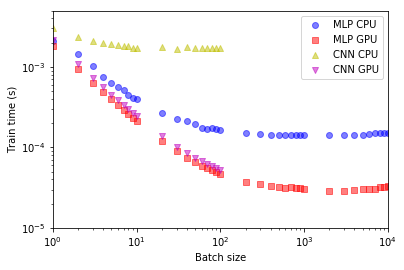

In [20]:
plt.scatter(x_mlp, mlp_cpu.train_times, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.train_times, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.train_times, c='y', alpha = 0.5, marker='^')
plt.scatter(x_cnn, cnn_gpu.train_times, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.00001, 0.005])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

This is the time per inference of each model, only counting the time to produce the generator.

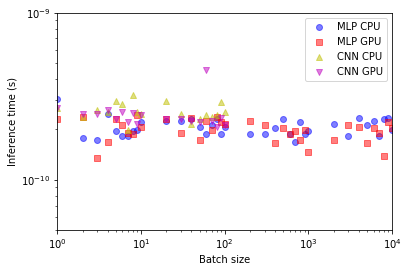

In [22]:
plt.scatter(x_mlp, mlp_cpu.inference_times_bare, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.inference_times_bare, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.inference_times_bare, c='y', alpha = 0.5, marker='^')
plt.scatter(x_cnn, cnn_gpu.inference_times_bare, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Inference time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.00000000005, 0.000000001])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

And this is the time per inference to produce the generator, and then pull every object from the generator and read its prediction.

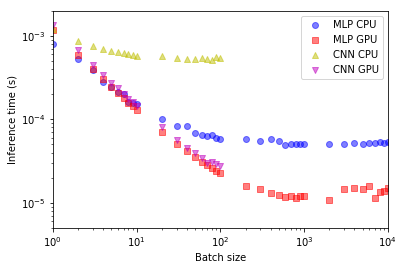

In [28]:
plt.scatter(x_mlp, mlp_cpu.inference_times_array, c='b', alpha = 0.5)
plt.scatter(x_mlp, mlp_gpu.inference_times_array, c='r', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_cpu.inference_times_array, c='y', alpha = 0.5, marker='^')
plt.scatter(x_cnn, cnn_gpu.inference_times_array, c='m', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Inference time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.000005, 0.002])
plt.legend(['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.show()

We can also plot the performance gain in using GPUs over CPUs. This is performance gain in train time.

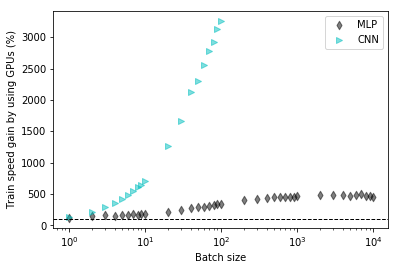

In [29]:
def get_improvement(cpu_times, gpu_times):
    gain = []
    for i in range(len(cpu_times)):
        gain.append(cpu_times[i] / gpu_times[i] * 100)
    return np.array(gain)

gain_train_mlp = get_improvement(mlp_cpu.train_times, mlp_gpu.train_times)
gain_train_cnn = get_improvement(cnn_cpu.train_times, cnn_gpu.train_times)

plt.scatter(x_mlp, gain_train_mlp, c='k', alpha = 0.5, marker = 'd')
plt.scatter(x_cnn, gain_train_cnn, c='c', alpha = 0.5, marker = '>')
plt.xlabel('Batch size')
plt.ylabel('Train speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

This is the performance gain in inference time, just measuring the time to produce the generator. It should average 100%, since the time to produce the generator should be roughly constant regardless of batch size.

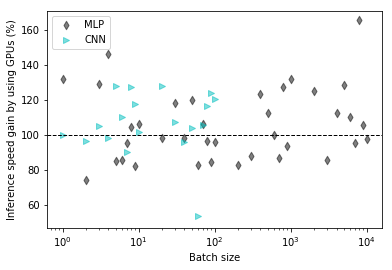

In [32]:
gain_inference_mlp = get_improvement(mlp_cpu.inference_times_bare, mlp_gpu.inference_times_bare)
gain_inference_cnn = get_improvement(cnn_cpu.inference_times_bare, cnn_gpu.inference_times_bare)
plt.scatter(x_mlp, gain_inference_mlp, c='k', alpha = 0.5, marker='d')
plt.scatter(x_cnn, gain_inference_cnn, c='c', alpha = 0.5, marker='>')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

Finally, this is performance gain measuring both the time to produce the generator (negligible) and the time to pack all the data into an array.

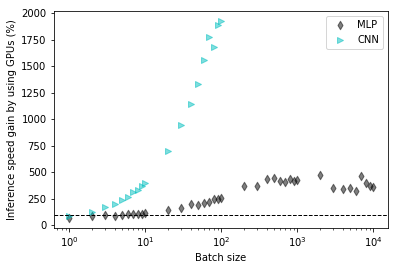

In [33]:
gain_inference_mlp = get_improvement(mlp_cpu.inference_times_array, mlp_gpu.inference_times_array)
gain_inference_cnn = get_improvement(cnn_cpu.inference_times_array, cnn_gpu.inference_times_array)
plt.scatter(x_mlp, gain_inference_mlp, c='k', alpha = 0.5, marker='d')
plt.scatter(x_cnn, gain_inference_cnn, c='c', alpha = 0.5, marker='>')
plt.xlabel('Batch size')
plt.ylabel('Inference speed gain by using GPUs (%)')
plt.xscale('log')
plt.yscale('linear')
plt.legend(['MLP', 'CNN'])
plt.axhline(100, linestyle='--', linewidth=1, color='k')
plt.show()

This concludes the experiment.